## Dataset

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark')

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

9


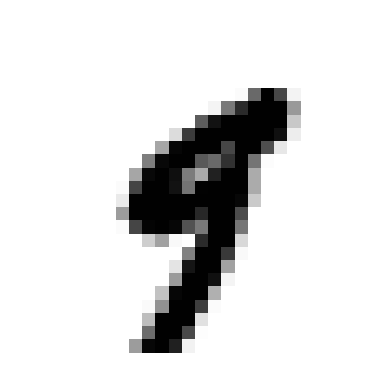

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
print(y[36000])

plt.imshow(some_digit_image, cmap='binary', interpolation='nearest')
plt.axis('off');

In [7]:
# Train Test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Shuffle
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

In [9]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

In [11]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([False])

In [15]:
sgd_scores = cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring='accuracy')
sgd_scores

array([0.94895, 0.8553 , 0.9136 ])

### Baseline

In [16]:
from sklearn.base import BaseEstimator

In [17]:
class Never9Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring='accuracy')

array([0.8988 , 0.9012 , 0.90255])

### Confusion Matrix

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [20]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)
y_train_pred.shape

(60000,)

In [21]:
confusion_matrix(y_train_9, y_train_pred)

array([[49160,  4891],
       [  752,  5197]])

In [27]:
precision = precision_score(y_train_9, y_train_pred)
recall = recall_score(y_train_9, y_train_pred)
f1 = f1_score(y_train_9, y_train_pred)

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1: {f1:.3f}')

Precision: 0.515
Recall: 0.874
F1: 0.648


### Precision/Recall Tradeoff

In [32]:
from sklearn.metrics import precision_recall_curve

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, method='decision_function')

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

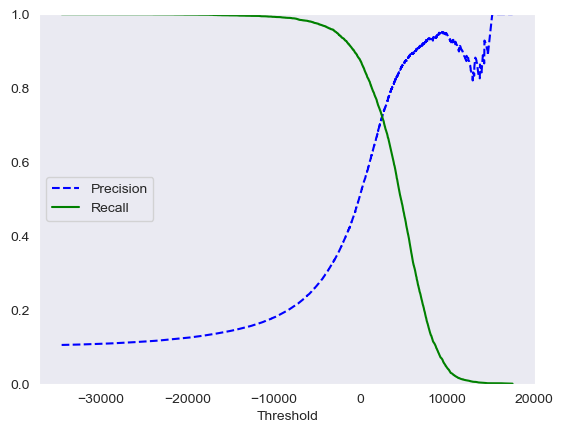

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    
# Call function
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

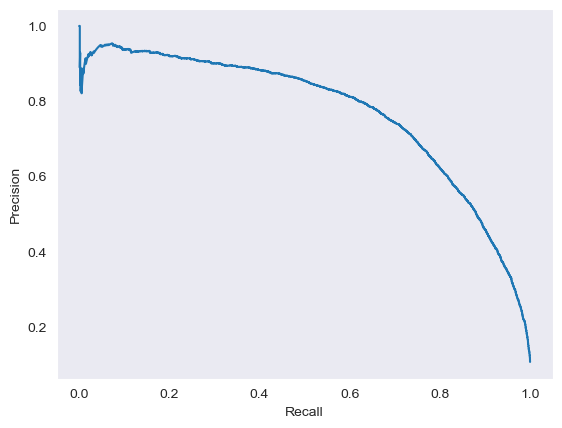

In [40]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
plot_precision_vs_recall(precisions, recalls)

### ROC Curve

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

In [43]:
fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)


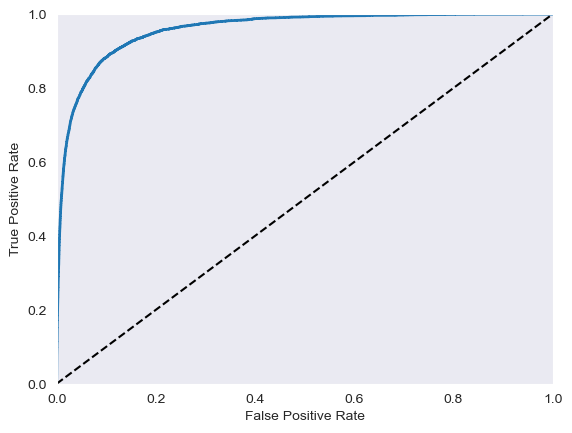

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [46]:
roc_auc_score(y_train_9, y_scores)

0.9583118984464343

### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

TypeError: cannot unpack non-iterable NoneType object

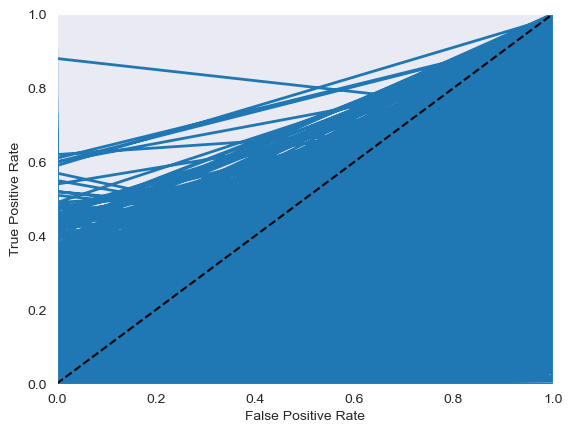

In [48]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1] # Use the positive class's probability

In [49]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

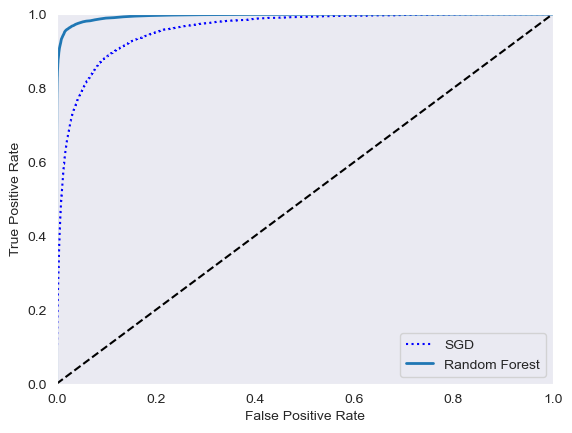

In [52]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right');

In [53]:
roc_auc_score(y_train_9, y_scores_forest)

0.9954620238615344

## Multiclass Classification

In [58]:
from sklearn.multiclass import OneVsOneClassifier

In [54]:
sgd_clf.fit(X_train, y_train) # One-vs-All
sgd_clf.predict([some_digit]) 

array([3])

In [56]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))

[[-34580.34697866 -19141.62171894 -24956.50922882  -1988.86999074
   -2762.11956842  -5836.19343625 -36499.91666606  -8289.8019788
   -3558.67061871  -4374.93454094]]
3


In [57]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [59]:
%%time

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

CPU times: user 28 s, sys: 110 ms, total: 28.1 s
Wall time: 28.1 s


array([4])

In [60]:
len(ovo_clf.estimators_)

45

In [61]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9])

In [62]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.01, 0.  , 0.  , 0.1 , 0.  , 0.  , 0.03, 0.01, 0.84]])

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8635 , 0.86285, 0.86545])

### Scaling

In [65]:
from sklearn.preprocessing import StandardScaler

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.9031 , 0.9016 , 0.89675])

# Error Analysis

In [67]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [69]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5589,    0,   17,    8,    8,   39,   36,    4,  221,    1],
       [   1, 6415,   44,   20,    3,   47,    4,    7,  191,   10],
       [  26,   29, 5264,   88,   69,   21,   70,   36,  347,    8],
       [  33,   18,  117, 5246,    2,  196,   20,   41,  393,   65],
       [  12,   14,   38,   10, 5219,   10,   35,   15,  332,  157],
       [  28,   17,   25,  158,   50, 4487,   73,   17,  505,   61],
       [  27,   16,   51,    2,   38,   93, 5542,    6,  143,    0],
       [  21,   16,   54,   25,   48,   12,    6, 5685,  196,  202],
       [  15,   57,   41,   95,    2,  120,   28,    7, 5446,   40],
       [  23,   23,   30,   62,  122,   33,    1,  170,  349, 5136]])

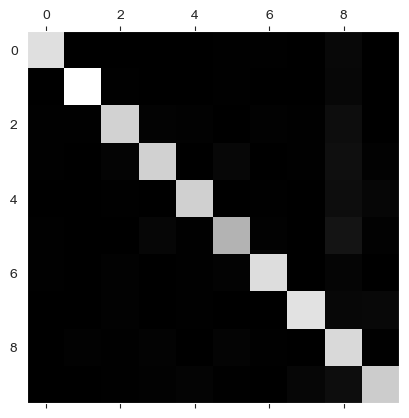

In [71]:
plt.matshow(conf_mx, cmap='gray');

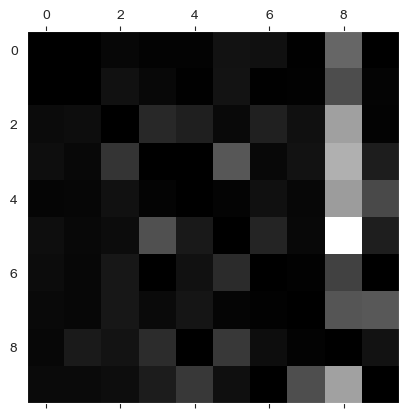

In [73]:
row_sums = conf_mx.sum(axis=1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap='gray')

## Multilabel Classification

In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 0)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [77]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [78]:
knn_clf.predict([some_digit])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[ True, False]])

In [80]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.9758501268320073